
# **Подгружаем все необходимые библиотеки и функции**

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import tensorflow.compat.v1 as tf
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Add
from keras.layers.core import Activation

import numpy as np
from numpy import genfromtxt
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt

import os
import sys
from PIL import Image
from skimage.io import imsave
from tqdm import tqdm, tqdm_notebook

sys.path.insert(1, 'drive/My Drive/Rosneft Seismic/models/modules')

from dice_metric import dice_coef, dice_coef_loss, bce_dice_coef_loss, find_threshold
from uresnet_v3 import uresnet3
from load_data_2 import load_data, load_test
from load_data_2 import cut_test_img, connect_test_img

Mounted at /content/drive


# **Инициализируем константы**

In [0]:
K.set_image_data_format('channels_last')                # Формат последнего канала

LAYER = '0'                                             # Номер слоя земли
VERSION = 5                                             # Версия самбита
EPOCHS = 20                                             # Количество эпох обучения (чтобы укладывалось в 12 часов)
BATCH_SIZE = 2                                          # Размер батча обучения (максимально позволительное GPU)
VERBOSE = 1                                             # Подробности обучения
OPTIMIZER = Adam(lr=5e-6)                               # Оптимизатор 
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 384, 384, 1          # Размеры используемых моделью изображений
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, IMG_CHANNELS)
FILEPATH = 'drive/My Drive/Rosneft Seismic/models/weight/weights_layer_'+LAYER+'_v'+str(VERSION)+'.h5' # Путь к модели

# **Загружаем тренировочную и валидационную выборку слоя LAYER**

In [8]:
x_valid, y_valid = load_data(LAYER, val=True)
x_train, y_train = load_data(LAYER, val=False)

LOAD VALIDATION DATA
--load inline images



--load xline images



END LOAD VALIDATION DATA
STAR PREPROCCECING
END PREPROCCECING
LOAD TRAIN DATA
--load inline images



--load xline images



END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING


# **Запускаем обучение сети**


In [9]:
model = uresnet3(IMG_ROWS, IMG_COLS, IMG_CHANNELS, OPTIMIZER)

model_checkpoint = ModelCheckpoint(filepath=FILEPATH, monitor='val_loss', save_best_only=True)
#history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, 
#                    shuffle=True, validation_data=(x_valid, y_valid), callbacks=[model_checkpoint])

dir_name = ['inline_1647','inline_1740','inline_1829','inline_1976','inline_3671',
            'xline_591','xline_550', 'inline_2797','inline_3037','inline_1333']

check_path = 'drive/My Drive/Rosneft Seismic/train/check_pic/'
img_path = '/content/drive/My Drive/Rosneft Seismic/test/images/'

for i in range(EPOCHS):
  history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1, verbose=VERBOSE, 
                      shuffle=True, validation_data=(x_valid, y_valid), callbacks=[model_checkpoint])
  for name in dir_name:
    img = np.array(Image.open(img_path+name+'.png'))
    img = img.astype('float32')
    img = img[:, :, 0]*0.299 + img[:, :, 1]*0.587 + img[:, :, 2]*0.114
    size, cut_image = cut_test_img(img)
    predict = model.predict(cut_image, verbose=0)
    predict = predict[:, :, :, 0, :]
    y_check = connect_test_img(size, predict)
    y_check = np.where(y_check < 0.5, 0, 255)
    y_check = y_check.astype(np.uint8)
    imsave(check_path+name+'/e'+str(i)+'.png', y_check)


Train on 3072 samples, validate on 256 samples
Epoch 1/1
3072/3072 [==============================] - 1672s 544ms/step - loss: 0.1547 - dice_coef: 0.8053 - val_loss: 0.0738 - val_dice_coef: 0.8953
Train on 3072 samples, validate on 256 samples
Epoch 1/1
3072/3072 [==============================] - 1661s 541ms/step - loss: 0.0362 - dice_coef: 0.9467 - val_loss: 0.0602 - val_dice_coef: 0.9279
Train on 3072 samples, validate on 256 samples
Epoch 1/1
3072/3072 [==============================] - 1660s 540ms/step - loss: 0.0203 - dice_coef: 0.9700 - val_loss: 0.0422 - val_dice_coef: 0.9507
Train on 3072 samples, validate on 256 samples
Epoch 1/1
3072/3072 [==============================] - 1658s 540ms/step - loss: 0.0131 - dice_coef: 0.9807 - val_loss: 0.0302 - val_dice_coef: 0.9597
Train on 3072 samples, validate on 256 samples
Epoch 1/1
3072/3072 [==============================] - 1655s 539ms/step - loss: 0.0095 - dice_coef: 0.9862 - val_loss: 0.0291 - val_dice_coef: 0.9634
Train on 3072 s

## **Строим графики**

dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef'])


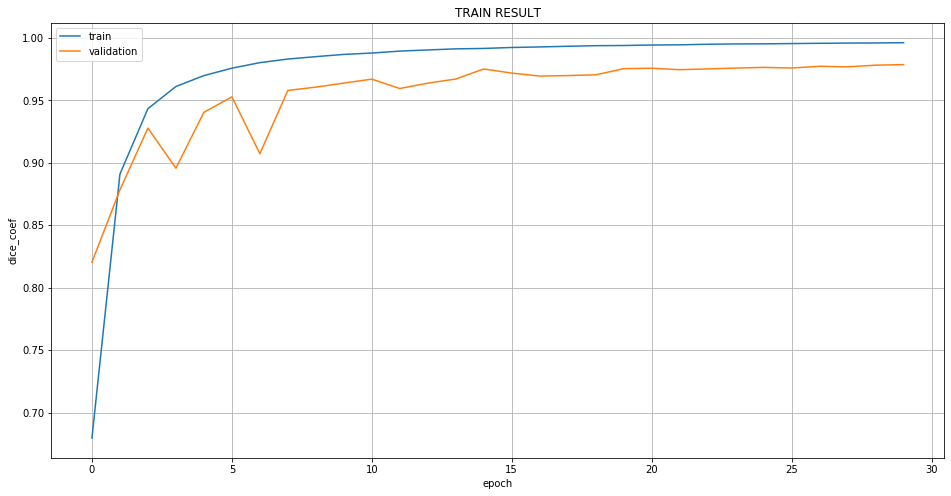

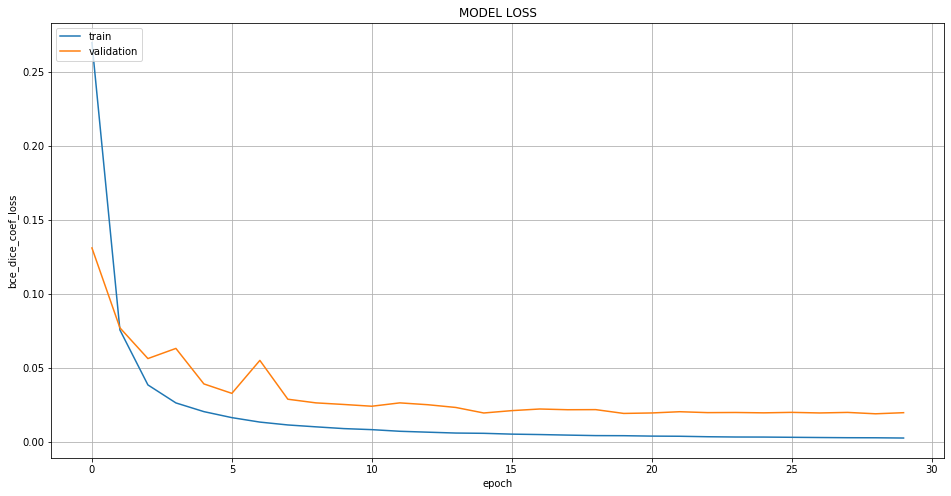

In [0]:
print(history.history.keys())
plt.figure(figsize=(16, 8))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('TRAIN RESULT')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('bce_dice_coef_loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

## **Дополнительные эпохи обучения**


In [0]:
ADD_EPOCHS = 3

model = load_model(FILEPATH, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=ADD_EPOCHS, verbose=VERBOSE, 
                    shuffle=True, validation_split=VALIDATION_SPLIT, callbacks=[model_checkpoint])

## **Архитектура модели**

In [0]:
model.summary()

# **Загружаем модель слоя LAYER**
 **Подбираем соответвующий treshold**


(?, ?, ?, ?)
(?, 384, 384, 1)
LOAD VALIDATION DATA
--load inline images



--load xline images



END LOAD VALIDATION DATA
STAR PREPROCCECING
END PREPROCCECING
LOAD TRAIN DATA
--load inline images



--load xline images



END LOAD TRAIN DATA
STAR PREPROCCECING
END PREPROCCECING
3328/3328 [==============================] - 307s 92ms/step


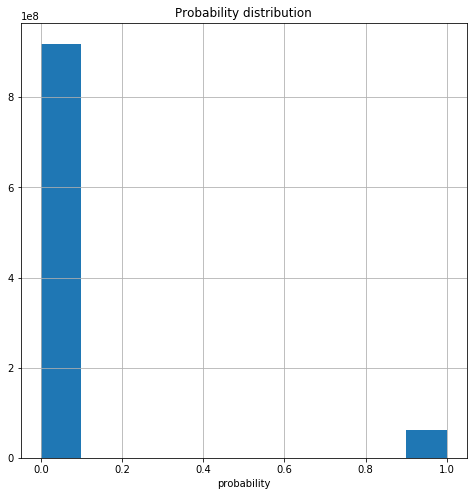

In [0]:
model = load_model(FILEPATH, custom_objects={'bce_dice_coef_loss': bce_dice_coef_loss, 'dice_coef': dice_coef})

x_valid, y_valid = load_data(LAYER, val=True)
x_train, y_train = load_data(LAYER, val=False)

x_full = np.concatenate((x_train, x_valid), axis = 0)
y_full = np.concatenate((y_train, y_valid), axis = 0)
y_pred = model.predict(x_full, verbose=1)

plt.figure(figsize=(8, 8))
plt.hist(y_pred.flatten())
plt.title('Probability distribution')
plt.xlabel('probability')
plt.grid()
plt.show()

#threshold = find_threshold(y_full, y_pred)
#print(threshold)

# **Загружаем тестовую выборку слоя LAYER**

In [0]:
test_name, x_test = load_test()

# **Запускаем модель на тестовой выборке**

In [0]:
test_path = 'drive/My Drive/Rosneft Seismic/test/answer/' + LAYER + '/'
for name, image in tqdm(zip(test_name, x_test)):
  image = list(image)
  size, cut_image = cut_test_img(image)

  predict = model.predict(cut_image, verbose=0)
  predict = predict[:, :, :, 0, :]
  y_test = connect_test_img(size, predict)
  y_test = np.where(y_test < 0.5, 0, 255)
  y_test = y_test.astype(np.uint8)

  imsave(test_path+name, y_test)


1871it [20:27,  2.67it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3584.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1873it [20:28,  2.81it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3593.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1875it [20:29,  2.94it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3577.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1879it [20:30,  2.86it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: drive/My Drive/Rosneft Seismic/test/answer/0/inline_3591.png is a low contrast image
  warn('%s is a low contrast image' % fname)
1880it [20:30,  3.12it/s]/usr/local/lib/python3.6/dist-packages/skimage/io/_io.p